> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, we select randomly sample 512 x 32 x 2 grid points of a solution of ASDM for a 32 x 32 grid, integerated for 0 to 50000 for 512 time steps. 

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model, however, we do not feed all the grid points in training part. On average 32 x2 data point exists for each time step, around 65/1024=6.25% of the data.

In [1]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32)#tf.Variable([0.005], dtype=tf.float32)
            self.D_s = tf.constant(0.2, dtype=tf.float32)#tf.Variable([0.2], dtype=tf.float32)
            self.sigma_a = tf.constant(0.0, dtype=tf.float32)#tf.Variable([0.0], dtype=tf.float32)
            self.sigma_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([0.25], dtype=tf.float32)

            # tf placeholders and graph
            self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                         log_device_placement=True))

            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
            self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
            self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

            self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
            self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

            self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

            self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

            self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

            self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")

            self.loss = self.loss_1 + self.loss_a + self.loss_s        

            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                    method = 'L-BFGS-B', 
                                                                    options = {'maxiter': 50000,
                                                                               'maxfun': 50000,
                                                                               'maxcor': 50,
                                                                               'maxls': 50,
                                                                               'ftol' : 1.0 * np.finfo(float).eps})        

            self.optimizer_Adam = tf.train.AdamOptimizer()
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    

            init = tf.global_variables_initializer()
            self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss},\n"
              f"D_a: {D_a:.4f}, D_s: {D_s:.4f}\n"
              f"sigma_a: {sigma_a:.4f}, sigma_s: {sigma_s:.4f}\n"
              f"rho_a: {rho_a:.4f}, rho_s: {rho_s:.4f}\n"
              f"mu_a: {mu_a:.4f}, kappa_a: {kappa_a:.4f}\n")
        
      
    def train(self, nIter, early_stop_thresh = None): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"It: {it}, loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"It: {it}, loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss, self.D_a, self.D_s,
        #                                  self.sigma_a, self.sigma_s,
        #                                  self.rho_a, self.rho_s,
        #                                  self.mu_a, self.kappa_a],
        #                        loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
idx = np.random.choice(N*T, T*32*2, replace=False)
#idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [4]:
s_train.shape

(32768, 1)

In [ ]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train(400000, early_stop_thresh=1000.0)

It: 0, loss_a  : 0.00492548, loss_s  : 13.10560226, loss  : 92075.37,
It: 0, loss_a/N: 0.00000015, loss_s/N: 0.00039995, loss/N: 2.80991721,
Time:3.41

It: 100, loss_a  : 0.00385652, loss_s  : 0.03985721, loss  : 8711.26,
It: 100, loss_a/N: 0.00000012, loss_s/N: 0.00000122, loss/N: 0.26584661,
Time:100.86

It: 200, loss_a  : 0.00230896, loss_s  : 0.02680406, loss  : 8703.78,
It: 200, loss_a/N: 0.00000007, loss_s/N: 0.00000082, loss/N: 0.26561838,
Time:100.95

It: 300, loss_a  : 0.00206273, loss_s  : 0.02433380, loss  : 8700.08,
It: 300, loss_a/N: 0.00000006, loss_s/N: 0.00000074, loss/N: 0.26550546,
Time:100.68

It: 400, loss_a  : 0.00192195, loss_s  : 0.02294684, loss  : 8697.36,
It: 400, loss_a/N: 0.00000006, loss_s/N: 0.00000070, loss/N: 0.26542228,
Time:100.66

It: 500, loss_a  : 0.00184002, loss_s  : 0.02218687, loss  : 8695.04,
It: 500, loss_a/N: 0.00000006, loss_s/N: 0.00000068, loss/N: 0.26535159,
Time:100.73

It: 600, loss_a  : 0.00179871, loss_s  : 0.02190270, loss  : 8692.67

In [6]:
model.train(400000, early_stop_thresh=1000.0)

It: 0, loss_a  : 0.01446236, loss_s  : 1.05884826, loss  : 999.28,
It: 0, loss_a/N: 0.00000044, loss_s/N: 0.00003231, loss/N: 0.03049571,
Time:1.02

##################################################
         Early stop
##################################################
It: 0, loss_a  : 0.01446236, loss_s  : 1.05884826, loss  : 999.28,
It: 0, loss_a/N: 0.00000044, loss_s/N: 0.00003231, loss/N: 0.03049571,
Time:0.00



In [27]:
model.train(400000, early_stop_thresh=320.0)

It: 0, loss_a  : 0.01447067, loss_s  : 1.05860591, loss  : 998.82,
It: 0, loss_a/N: 0.00000044, loss_s/N: 0.00003231, loss/N: 0.03048157,
Time:1.03

It: 100, loss_a  : 0.01416034, loss_s  : 1.03627992, loss  : 962.23,
It: 100, loss_a/N: 0.00000043, loss_s/N: 0.00003162, loss/N: 0.02936479,
Time:101.36

It: 200, loss_a  : 0.01376269, loss_s  : 1.00598526, loss  : 910.17,
It: 200, loss_a/N: 0.00000042, loss_s/N: 0.00003070, loss/N: 0.02777627,
Time:100.90

It: 300, loss_a  : 0.01341284, loss_s  : 0.98402226, loss  : 871.72,
It: 300, loss_a/N: 0.00000041, loss_s/N: 0.00003003, loss/N: 0.02660282,
Time:100.88

It: 400, loss_a  : 0.01311567, loss_s  : 0.96530956, loss  : 831.47,
It: 400, loss_a/N: 0.00000040, loss_s/N: 0.00002946, loss/N: 0.02537455,
Time:101.38

It: 500, loss_a  : 0.01276673, loss_s  : 0.94814277, loss  : 810.76,
It: 500, loss_a/N: 0.00000039, loss_s/N: 0.00002894, loss/N: 0.02474256,
Time:100.68

It: 600, loss_a  : 0.01257725, loss_s  : 0.93271941, loss  : 750.37,
It: 600

In [63]:
model.train(400000, early_stop_thresh=100.0)

It: 0, loss_a  : 0.00997662, loss_s  : 0.71223521, loss  : 319.85,
It: 0, loss_a/N: 0.00000030, loss_s/N: 0.00002174, loss/N: 0.00976094,
Time:1.03

It: 100, loss_a  : 0.00988784, loss_s  : 0.70199633, loss  : 310.67,
It: 100, loss_a/N: 0.00000030, loss_s/N: 0.00002142, loss/N: 0.00948081,
Time:102.30

It: 200, loss_a  : 0.00969460, loss_s  : 0.69445145, loss  : 303.65,
It: 200, loss_a/N: 0.00000030, loss_s/N: 0.00002119, loss/N: 0.00926674,
Time:100.61

It: 300, loss_a  : 0.00971825, loss_s  : 0.68475997, loss  : 294.02,
It: 300, loss_a/N: 0.00000030, loss_s/N: 0.00002090, loss/N: 0.00897276,
Time:102.52

It: 400, loss_a  : 0.00961314, loss_s  : 0.67493522, loss  : 287.05,
It: 400, loss_a/N: 0.00000029, loss_s/N: 0.00002060, loss/N: 0.00876011,
Time:106.51

It: 500, loss_a  : 0.00956011, loss_s  : 0.66996145, loss  : 279.58,
It: 500, loss_a/N: 0.00000029, loss_s/N: 0.00002045, loss/N: 0.00853207,
Time:106.50

It: 600, loss_a  : 0.00947621, loss_s  : 0.66289783, loss  : 273.16,
It: 600

It: 5300, loss_a  : 0.00752547, loss_s  : 0.51942027, loss  : 175.97,
It: 5300, loss_a/N: 0.00000023, loss_s/N: 0.00001585, loss/N: 0.00537021,
Time:100.39

It: 5400, loss_a  : 0.00981294, loss_s  : 0.55307293, loss  : 292.69,
It: 5400, loss_a/N: 0.00000030, loss_s/N: 0.00001688, loss/N: 0.00893231,
Time:100.34

It: 5500, loss_a  : 0.00707775, loss_s  : 0.48646855, loss  : 122.35,
It: 5500, loss_a/N: 0.00000022, loss_s/N: 0.00001485, loss/N: 0.00373383,
Time:100.39

It: 5600, loss_a  : 0.00786399, loss_s  : 0.49664694, loss  : 155.77,
It: 5600, loss_a/N: 0.00000024, loss_s/N: 0.00001516, loss/N: 0.00475382,
Time:102.22

It: 5700, loss_a  : 0.00702318, loss_s  : 0.48247671, loss  : 119.63,
It: 5700, loss_a/N: 0.00000021, loss_s/N: 0.00001472, loss/N: 0.00365084,
Time:106.90

It: 5800, loss_a  : 0.00699794, loss_s  : 0.48027036, loss  : 118.37,
It: 5800, loss_a/N: 0.00000021, loss_s/N: 0.00001466, loss/N: 0.00361239,
Time:109.06

It: 5900, loss_a  : 0.00687614, loss_s  : 0.47988176, loss

In [91]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = 256#T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[:T_2]#t_star[-T_2:]

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [92]:
t_2.shape

(262144, 1)

In [93]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)


print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")


Loss_a : 0.04826954
Loss_s : 3.18725538


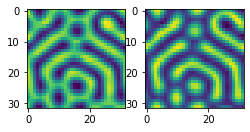

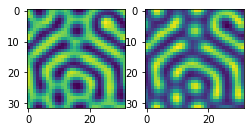

In [94]:
start = 255
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, start].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, start].reshape((x_size,y_size)))
plt.show()

#plt.subplot(131)
#plt.imshow(data[0, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.subplot(132)
#plt.imshow(data[1, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.show()

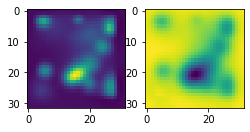

In [70]:
plt.subplot(131)
plt.imshow(data[0, :, :, 1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, 1].reshape((x_size,y_size)))
plt.show()

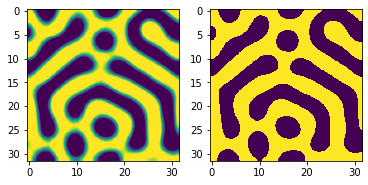

In [71]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)), interpolation='gaussian')

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)), interpolation='gaussian')
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol.gif', writer='imagemagick')

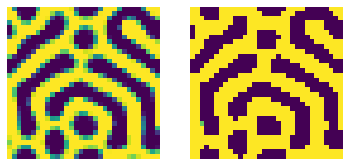

In [99]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.axis('off')
ax2.axis('off')

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)))

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)))
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_2.gif', writer='imagemagick')

In [86]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = 80000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [87]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00116302
Loss_s : 0.05677272
Loss   : 294.76751709


In [88]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

269.8975177701667
24.81206733305877


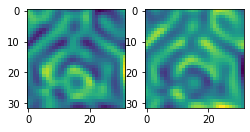

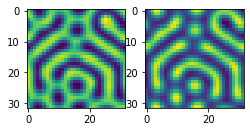

In [89]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, -1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, -1].reshape((x_size,y_size)))
plt.show()

In [64]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_sampled', global_step=0)

'./PINN_Turring_model_loss_sampled-0'

In [65]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf:0
y_tf:0
t_tf:0
a_pred:0
s_pred:0
add_10:0
loss_a:0
loss_s:0


In [48]:
print(np.sum(np.power(a_2 - a_train,2)))
print(np.sum(np.power(s_2 - s_train,2)))
print(np.sum(np.power(a_2 - a_train,2)) +
      np.sum(np.power(s_2 - s_train,2)))

ValueError: operands could not be broadcast together with shapes (262144,1) (32768,1) 